# Image Segmentation on a U-Net Convulotional Neural Network

## Machine Learning Capstone

### Alexander Graff
### June 2nd, 2018

### Intro
The mission is simple, create a seperate black and white representation also known as a mask, of each cell nuclei given in an image. The process of creating a simplified version or creating different segments of an area is known as image segmentation. The data is provided by the Booz Allen Hamilton Data Science Bowel. U-nets were chosen due to their proven ability to segment microscopic images. The first step is getting the training and test data. I have already downloaded the first round of training a testing data. Lets take a look at the first couple of trainining images and their associated masks.

In [3]:
# We use this to read image files in python, 
# default intepertation of an image is RGB
import os
from skimage.io import imread, imshow
from skimage.transform import resize

import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
earlystopper = EarlyStopping(patience=5, verbose=1)
import tensorflow as tf


Using TensorFlow backend.


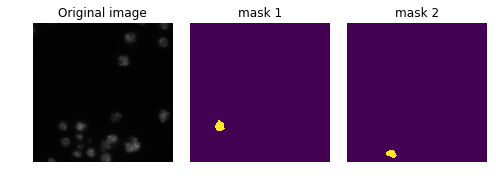

In [4]:
# Lets read some of our images
target = "./data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png"
mask = "./data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png"
mask2 = "./data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png"

target = imread(target)
mask = imread(mask)
mask2 = imread(mask2)
# Creates the nice graphic
fig, axes = plt.subplots(1, 3, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(target)
ax[0].set_title("Original image")

ax[1].imshow(mask)
ax[1].set_title("mask 1")

ax[2].imshow(mask2)
ax[2].set_title("mask 2")

# Removes the axis labels...
for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Lets create the training and testing datasets now. First we'll need to establish how large we want our images to be. The smallest image in the training set is 256, this will be our image size.


In [5]:
## SETTINGS
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Training and testing data path
TRAIN_PATH = "./data/stage1_train/"
TEST_PATH = "./data/stage1_test/"
# Get the ids
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# Set the dimensions of the of the training data, we have 670 images
# Dimensions: (670, 256, 256, 3) 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# Load up the training images and masks
for n, id_ in enumerate(train_ids):
    img = imread(TRAIN_PATH + id_ + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    # Make sure the image is 256x256, we can change this value above by the constant
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    # Prepare the corresponding maskss
    # shape 256x256x1 (only black and white so one channel)
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # For each mask, resize the image to 256x256, then add a color channel resulting in a (256,265,1) matrix.
    # Then, add the resized matrix image to the final combined training mask by taking the maximum value of
    # the two matrices or in other words, where the mask , resulting in the expected combined mask.
    for mask_file in next(os.walk(TRAIN_PATH + id_ + '/masks/'))[2]:
        mask_ = imread(TRAIN_PATH + id_ + '/masks/' + mask_file)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
print(Y_train[1].shape)
# Load the test data sets
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
for n, id_ in  enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print(X_train.shape)
print('Done!')

/home/graffam/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256, 1)
Getting and resizing test images ... 
(670, 256, 256, 3)
Done!


Lets display some of the data to see if everything looks okay:

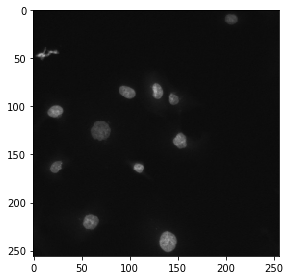

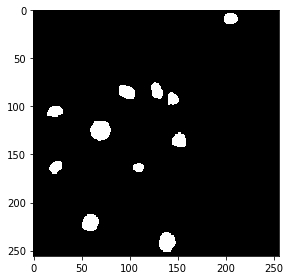

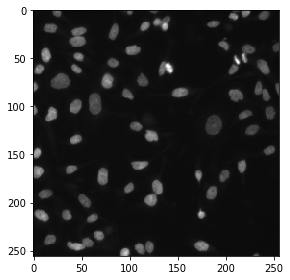

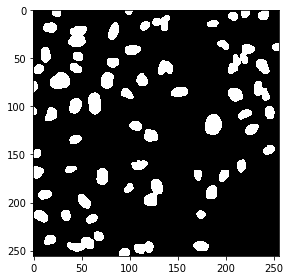

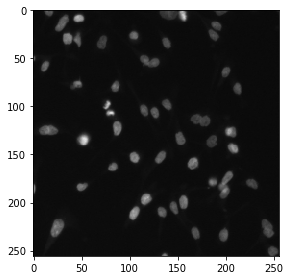

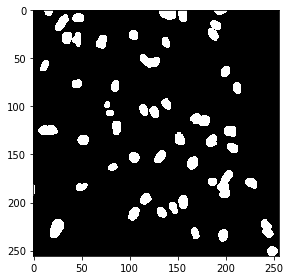

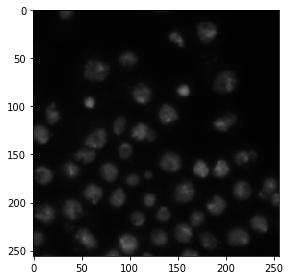

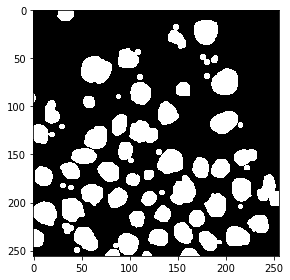

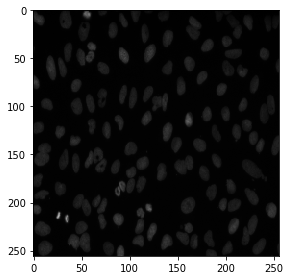

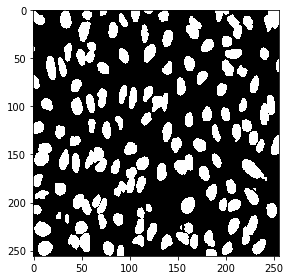

In [6]:
for i in range(0,5):
    imshow(X_train[i])
    plt.show()
    imshow(np.squeeze(Y_train[i]))
    plt.show()

We need to calculate the IoU per perdicted mask. Then check to see if it falls within the range of thresholds.

In [7]:
# Define IoU metric (Knicked from https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric)
# Using the basic one that might not work for now:
# Define IoU metric
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [8]:
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
def get_unet():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    return model


# Fit the model!
model = get_unet()
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [7]:
# Setup the early check pointing:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

# Runtime custom callbacks
# https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

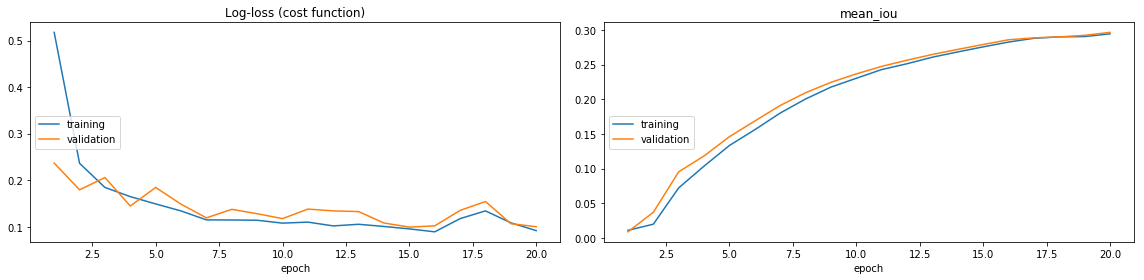

Epoch 00020: early stopping


In [31]:
# Fit model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer, plot_losses])

In [12]:
# Predict on train, val and test
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/step


/home/graffam/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


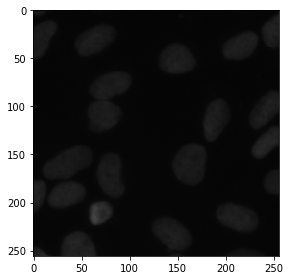

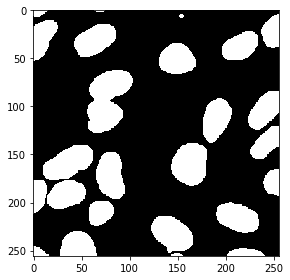

/home/graffam/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


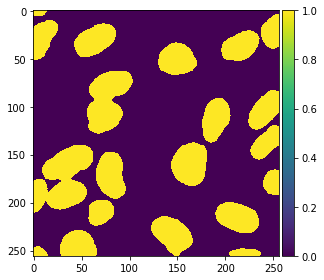

In [14]:
import random
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

This model performs well if just looking at the resultant images, but the loss and IoU scores are not precise enough for medical imaging.

Epoch 00022: val_loss improved from 0.06952 to 0.06844, saving model to model-dsbowl2018-1.h5
Epoch 23/30
603/603 [==============================] - 2s 4ms/step - loss: 0.0713 - mean_iou: 0.3340 - val_loss: 0.0723 - val_mean_iou: 0.3356

The next step is to attempt to augment the images to increase the batch and validataion set sizes. This in theory will create a better model.

In [17]:
import imgaug as ia
from imgaug import augmenters as iaa


In [18]:
# Create a new version of the mask and the image, horizontaly flip, vertically flip, horizontally and vertically flip
# This will artificially increase the training set size by a factor of 3.
vert_flipper = iaa.Fliplr(1.0)
horizontal_flipper = iaa.Flipud(1.0)
X_train_aug = np.zeros((len(train_ids) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_aug = np.zeros((len(train_ids) * 4, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for i in range(0, len(X_train)):
    X_train_aug[i * 4] = X_train[i]
    Y_train_aug[i * 4] = Y_train[i]
    X_train_aug[i * 4 + 1] = vert_flipper.augment_image(X_train[i])
    Y_train_aug[i * 4 + 1] = vert_flipper.augment_image(Y_train[i])
    X_train_aug[i * 4 + 2] = horizontal_flipper.augment_image(X_train[i])
    Y_train_aug[i * 4 + 2] = horizontal_flipper.augment_image(Y_train[i])
    X_train_aug[i * 4 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(X_train[i]))
    Y_train_aug[i * 4 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(Y_train[i]))




In [19]:
print(X_train_aug.shape)

(2680, 256, 256, 3)


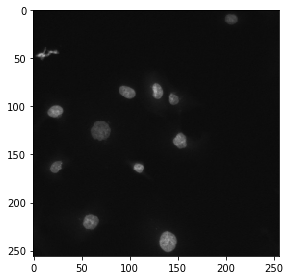

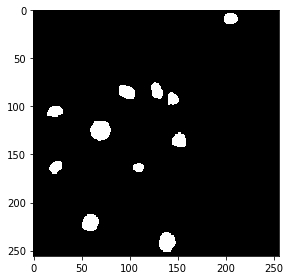

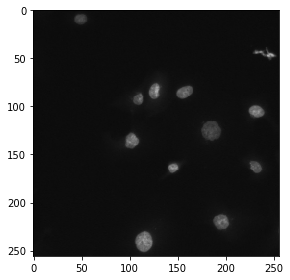

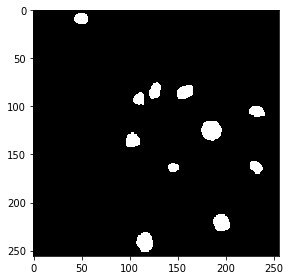

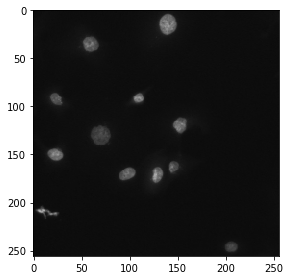

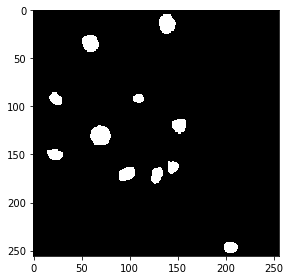

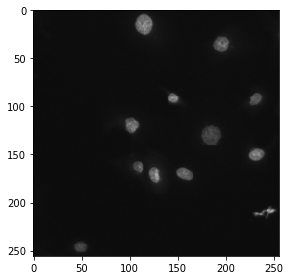

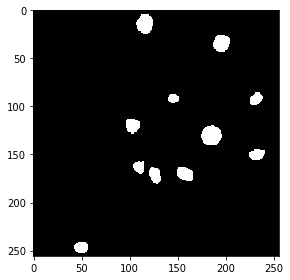

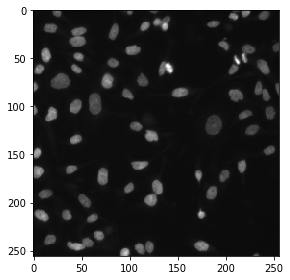

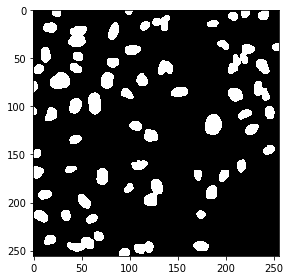

In [20]:
# A Quick sanity check 
for i in range(0,5):
    imshow(X_train_aug[i])
    plt.show()
    imshow(np.squeeze(Y_train_aug[i]))
    plt.show()

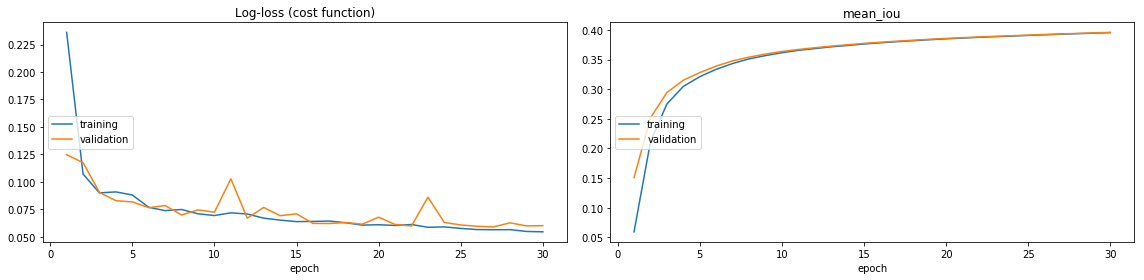

In [12]:
# Setup the early check pointing:
checkpointer = ModelCheckpoint('model_improved-dsbowl2018-1.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)
model_improved = get_unet()
results2 = model_improved.fit(X_train_aug, Y_train_aug, shuffle=True, validation_split=0.1, batch_size=3, epochs=30, 
                    callbacks=[earlystopper, checkpointer, plot_losses])

This improved the initial model from roughly .30 mean IOU to to .39 IOU. If we further increased the augmentation it might be possible to atleast achieve a mean_iou of .5. Lets try that now. Instead of just flipping the images, lets also rotate them. lets try that out now.

In [15]:
# Create a new version of the mask and the image, horizontaly flip, vertically flip, horizontally and vertically flip
# This will artificially increase the training set size by a factor of 6.
vert_flipper = iaa.Fliplr(1.0)
horizontal_flipper = iaa.Flipud(1.0)
rotator_90 = iaa.Affine(rotate=(0, 90))
rotator_270 = iaa.Affine(rotate=(0,-90))
X_train_aug = np.zeros((len(train_ids) * 6, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_aug = np.zeros((len(train_ids) * 6, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# There has to be a better way to do this
for i in range(0, len(X_train)):
    X_train_aug[i * 6] = X_train[i]
    Y_train_aug[i * 6] = Y_train[i]
    X_train_aug[i * 6 + 1] = vert_flipper.augment_image(X_train[i])
    Y_train_aug[i * 6 + 1] = vert_flipper.augment_image(Y_train[i])
    X_train_aug[i * 6 + 2] = horizontal_flipper.augment_image(X_train[i])
    Y_train_aug[i * 6 + 2] = horizontal_flipper.augment_image(Y_train[i])
    X_train_aug[i * 6 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(X_train[i]))
    Y_train_aug[i * 6 + 3] = vert_flipper.augment_image(horizontal_flipper.augment_image(Y_train[i]))
    X_train_aug[i * 6 + 4] = rotator_90.augment_image(X_train[i])
    Y_train_aug[i * 6 + 4] = rotator_90.augment_image(Y_train[i])
    X_train_aug[i * 6 + 5] = rotator_270.augment_image(X_train[i])
    Y_train_aug[i * 6 + 5] = rotator_270.augment_image(Y_train[i])


In [16]:
print(X_train_aug.shape)

(4020, 256, 256, 3)


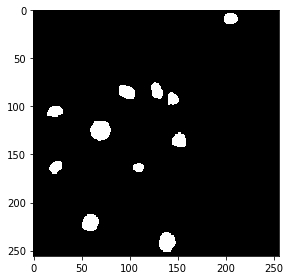

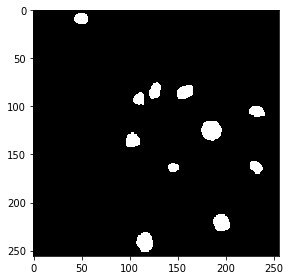

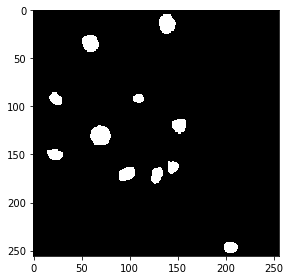

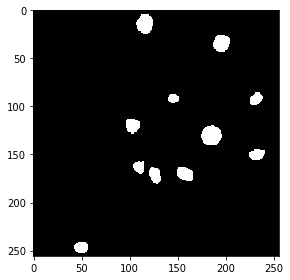

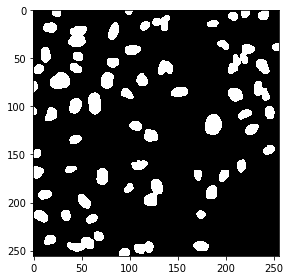

In [21]:
# A Quick sanity check 
for i in range(0, 5):
#     imshow(X_train_aug[i])
#     plt.show()
    imshow(np.squeeze(Y_train_aug[i]))
    plt.show()

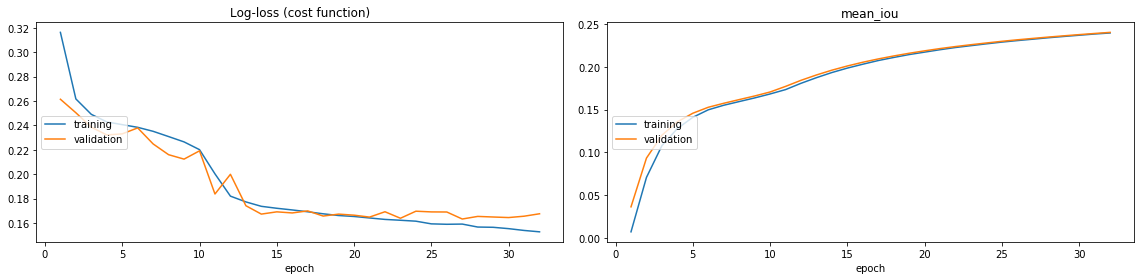

Epoch 00032: early stopping


In [23]:
# Setup the early check pointing:
checkpointer = ModelCheckpoint('model_improved2-dsbowl2018-1.h5', verbose=1, save_best_only=True)
model_improved_2 = get_unet()
results3 = model_improved_2.fit(X_train_aug, Y_train_aug, shuffle=True, validation_split=0.1, batch_size=5, epochs=100, 
                    callbacks=[earlystopper, checkpointer, plot_losses])

It appears adding more rotating has caused the model to actually perform worse and over fit. It is possible that the method of rotation has actually duplicated some of the same images, causing them to be represented more than once in the data set. Its also possible that there needs to be a probability introduced when flipping the images.

**EDIT** Re-ran with including the shuffle option as true when fitting the model, fixed the over fitting issue but the model is still not performing that well.

In [8]:
# Set seed values
import random
seed = 42
random.seed = seed
np.random.seed(seed=seed)
epochs = 100
validation_split = .10
batch_size= 2

from keras.preprocessing.image import ImageDataGenerator 
# It turns out there is a better way to augment images, lets try this again
# using Keras built in runtime data augmenter: https://keras.io/preprocessing/image/#image-preprocessing
# https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation/notebook
# we create two instances with the same arguments
class DataGenerator(object):
    def __init__(self):
        pass
    @staticmethod
    def generate_images(X_data=X_train, Y_data=Y_train, validation_split=0.25, batch_size=batch_size, seed=seed):
        X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                            Y_data,
                                                            train_size=1-validation_split,
                                                            test_size=validation_split,
                                                            random_state=seed)
        
        
        # Image data generator distortion options
        data_gen_args = dict(rotation_range=360.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??

        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)

        # Provide the same seed and keyword arguments to the fit and flow methods
        X_datagen = ImageDataGenerator(**data_gen_args)
        Y_datagen = ImageDataGenerator(**data_gen_args)
        X_datagen.fit(X_train, augment=True, seed=seed)
        Y_datagen.fit(Y_train, augment=True, seed=seed)
        X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
        Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
        
        
        
        # create another generator for the validation data, since using the model.fit_generator method
        X_datagen_val = ImageDataGenerator()
        Y_datagen_val = ImageDataGenerator()
        X_datagen_val.fit(X_test, augment=True, seed=seed)
        Y_datagen_val.fit(Y_test, augment=True, seed=seed)
        X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
        Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)

        train_generator = zip(X_train_augmented, Y_train_augmented)
        test_generator = zip(X_test_augmented, Y_test_augmented)
        
        # return them
        
        return train_generator, test_generator

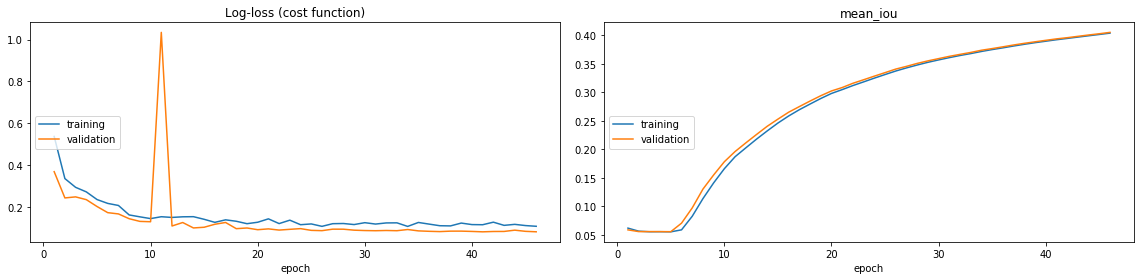

Epoch 00046: early stopping


In [22]:
# BATCH_SIZE OF 16
# Setup the early check pointing:
checkpointer = ModelCheckpoint('model_improved4-dsbowl2018-1.h5', verbose=1, save_best_only=True)
improved_model_4 = get_unet()
train_generator, test_generator = DataGenerator.generate_images(X_data=X_train, Y_data=Y_train, validation_split=validation_split, batch_size=batch_size)
# Settings suggested by the keras documentation, the validation steps/steps per epoch
improved_model_4.fit_generator(train_generator, validation_data=test_generator, validation_steps=len(X_test)/batch_size, steps_per_epoch=len(X_train)/(batch_size), epochs=epochs, callbacks=[checkpointer, earlystopper, plot_losses])

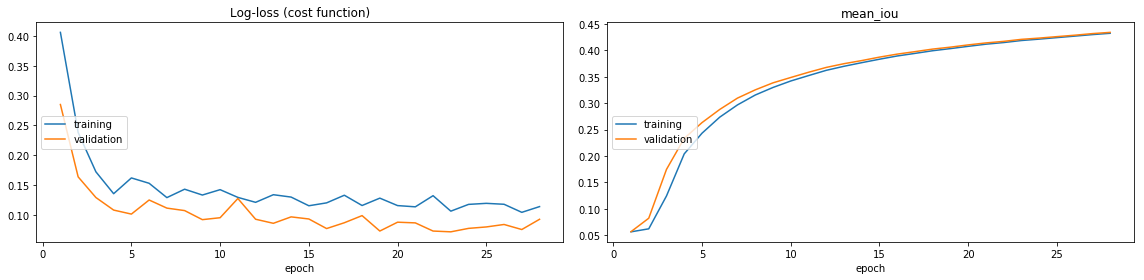

Epoch 00028: early stopping


In [30]:
# Batch size of 5
# Setup the early check pointing:
checkpointer = ModelCheckpoint('model_improved5-dsbowl2018-1.h5', verbose=1, save_best_only=True)
improved_model_5 = get_unet()
train_generator, test_generator = DataGenerator.generate_images(X_data=X_train, Y_data=Y_train, validation_split=validation_split, batch_size=5)
# Settings suggested by the keras documentation, the validation steps/steps per epoch
improved_model_5.fit_generator(train_generator, validation_data=test_generator, validation_steps=len(X_test)/batch_size, steps_per_epoch=len(X_train)/(batch_size), epochs=epochs, callbacks=[checkpointer, earlystopper, plot_losses])

In [31]:
# It seems to be that smaller batch sizes work the best, lets try a batch size of 2 for giggles.

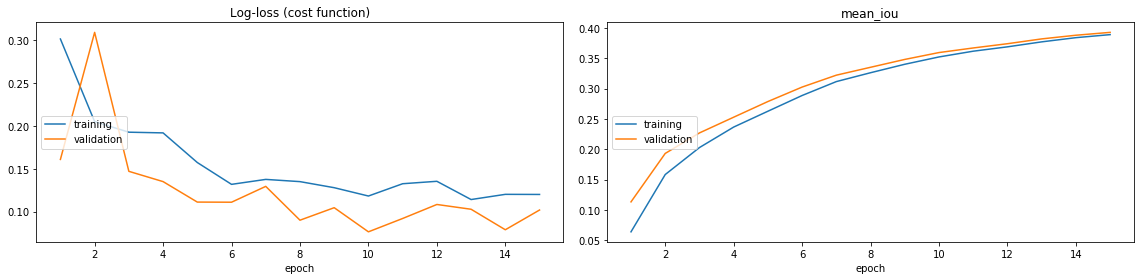

Epoch 00015: early stopping


In [14]:
# Batch size of 2
# Setup the early check pointing:
checkpointer = ModelCheckpoint('model_improved6-dsbowl2018-1.h5', verbose=1, save_best_only=True)
improved_model_6 = get_unet()
train_generator, test_generator = DataGenerator.generate_images(X_data=X_train, Y_data=Y_train, validation_split=validation_split, batch_size=2)
# Settings suggested by the keras documentation, the validation steps/steps per epoch
improved_model_6.fit_generator(train_generator, validation_data=test_generator, validation_steps=len(X_test)/batch_size, steps_per_epoch=len(X_train)/(batch_size), epochs=epochs, callbacks=[checkpointer, earlystopper, plot_losses])

In [13]:
# Predict on train, val and test
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
model_final = load_model('model_improved6-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model_final.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model_final.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model_final.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/step


/home/graffam/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


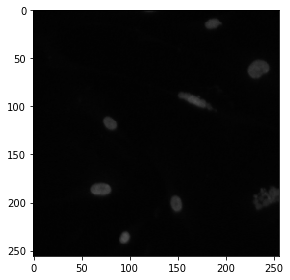

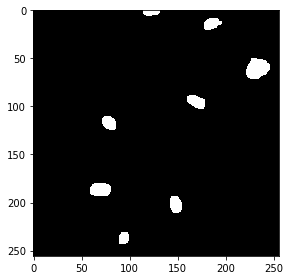

/home/graffam/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


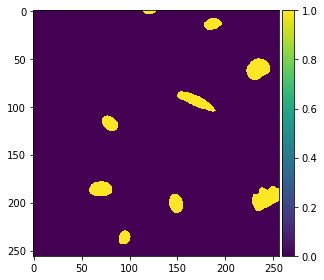

In [22]:
import random
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

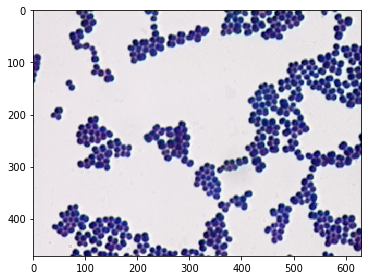

In [34]:
# Load a gram stain image from a completely unrelated set:
gram_stain = imread("./gram_stain.bmp")
imshow(gram_stain)

1/1 [==============================] - 0s 12ms/step


/home/graffam/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


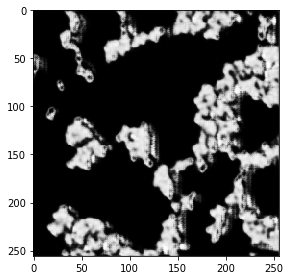

In [35]:
gram_stain = resize(gram_stain, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
gram_stain_tensor = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
gram_stain_tensor[0] = gram_stain
predicted_gram = model_final.predict(gram_stain_tensor, verbose=True)
imshow(np.squeeze(predicted_gram[0]))
plt.show()